# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [61]:
import urllib.request
import zipfile
import os.path
import nltk
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import pickle
import urllib.request
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [62]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
DATA_URL='https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
ROOT_FOLDER='./dsplus_integrated_project_4'
# исключаем повторную загрузку, если файл уже был ранее загружен
OUT_FILE=os.path.exists(ROOT_FOLDER + '.zip')
TRAIN_IMAGE_FOLDER=ROOT_FOLDER + '/to_upload/train_images'
TEST_IMAGE_FOLDER=ROOT_FOLDER + '/to_upload/test_images'
RANDOM_STATE=12345
# максимальное количество примеров
MAX_SAMPLE = 10
# папка для хранения временных данных
TMP='./cache'

In [64]:
Path(TMP).mkdir(parents=True, exist_ok=True)

In [65]:
if OUT_FILE == False:
    # скачиваем архив
    urllib.request.urlretrieve(DATA_URL, 'dsplus_integrated_project_4.zip')
    # распаковываем
    with zipfile.ZipFile('./dsplus_integrated_project_4.zip', 'r') as zip_ref:
        zip_ref.extractall(ROOT_FOLDER)

In [66]:
train_dataset_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/train_dataset.csv')

train_dataset_csv.info()

train_dataset_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [67]:
crowd_annotations_tsv = pd.read_csv(ROOT_FOLDER + '/to_upload/CrowdAnnotations.tsv',
                                    sep='\t',
                                    header=None,
                                    names=['image', 'query_id', 'positive', 'n1', 'n2'])

crowd_annotations_tsv.info()

crowd_annotations_tsv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   positive  47830 non-null  float64
 3   n1        47830 non-null  int64  
 4   n2        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,positive,n1,n2
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Описание колонок:

image - Имя файла изображения;
query_id - Идентификатор описания;
positive - Доля людей, подтвердивших, что описание соответствует изображению;
n1 - Количество человек, подтвердивших, что описание соответствует изображению;
n2 - Количество человек, подтвердивших, что описание не соответствует изображению.

In [68]:
expert_annotations_tsv = pd.read_csv(ROOT_FOLDER + '/to_upload/ExpertAnnotations.tsv',
                                     sep='\t',
                                     header=None,
                                     names=['image', 'query_id', 'n1', 'n2', 'n3'])

expert_annotations_tsv.reset_index(inplace=True, drop=True)

expert_annotations_tsv.info()

expert_annotations_tsv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   n1        5822 non-null   int64 
 3   n2        5822 non-null   int64 
 4   n3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,n1,n2,n3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Описание колонок:

image - Имя файла изображения;
query_id - Идентификатор описания;
n1 — оценка 1 эксперта;
n2 — оценка 2 эксперта;
n3 — оценка 3 эксперта.
Выполним обработку данных краудсорсинга:

добавим колонку n0 с агрегированной оценкой;
добавим колонку positive с долей, подтвердивших, что описание соотвествует изображению.
Эксперты ставят оценки по шкале от 1 до 4, где

1 — изображение и запрос совершенно не соответствуют друг другу;
2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
3 — запрос и текст соответствуют с точностью до некоторых деталей;
4 — запрос и текст соответствуют полностью.
Примечание: "положительными" будем считать оценки 3 и 4

In [69]:
# выполним обработку данных краудсорсинга
def calc_avg(row):
    """
    Вычисление результата "голосования" способом большинства

    Параметры:
    ----------
    row: Series

    Результат:
    ----------
    int - число
    """
    array = [row['n1'], row['n2'], row['n3']]
    u, c = np.unique(array, return_counts=True)

    # находим самую частую оценку
    y = u[c == c.max()]
    # вычисляем долю найденных оценок
    percentages = dict(zip(u, c / len(array)))

    # "позитивными" будем считать, тех у кого оценка 3 или 4
    row['n0'] = y[0] if len(y) == 1 else 0
    row['positive'] = percentages[y[0]] if len(y) == 1 and y[0] in [3, 4] else 0

    return row

In [70]:
expert_annotations_tsv = expert_annotations_tsv.apply(calc_avg, axis=1)

In [71]:
# удалим те мнения экспертов, где они полностью разошлись
expert_annotations_n0 = expert_annotations_tsv[expert_annotations_tsv['n0'] == 0]

display(expert_annotations_n0.head())

expert_annotations_tsv.drop(expert_annotations_n0.index, inplace=True)

,image,query_id,n1,n2,n3,n0,positive
17,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,1,2,3,0,0.0
40,1119015538_e8e796281e.jpg,2534502836_7a75305655.jpg#2,2,3,4,0,0.0
47,1122944218_8eb3607403.jpg,3325497914_f9014d615b.jpg#2,2,3,4,0,0.0
168,1287475186_2dee85f1a5.jpg,2918769188_565dd48060.jpg#2,1,2,3,0,0.0
199,1329832826_432538d331.jpg,1536774449_e16b1b6382.jpg#2,1,2,3,0,0.0


In [72]:
expert_annotations_tsv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5696 non-null   object 
 1   query_id  5696 non-null   object 
 2   n1        5696 non-null   int64  
 3   n2        5696 non-null   int64  
 4   n3        5696 non-null   int64  
 5   n0        5696 non-null   int64  
 6   positive  5696 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 356.0+ KB


In [73]:
# для удобства установим индексы
crowd_annotations_tsv.set_index(['image', 'query_id'], inplace=True)
expert_annotations_tsv.set_index(['image', 'query_id'], inplace=True)

In [74]:
annotations = crowd_annotations_tsv[['positive']].merge(
    expert_annotations_tsv[['positive']],
    how='outer', # используем это объединение, так как нужно соеденить все данные независимо от ключа
    left_index=True,
    right_index=True,
    suffixes=('_crowd', '_expert')
)

In [75]:
def join_positive_expert_priority(row):
    """
    Объединение оценок с приоритетом для экспертов

    Параметры:
    ----------
    row: Series

    Результат:
    ----------
    int - число
    """
    crowd = row['positive_crowd']
    expert = row['positive_expert']

    if expert >= 0:
        # важны только экспертные мнения
        return expert

    # если эксперты не давали оценку, а результат есть на кроудсорсинге
    if crowd >= 0 and expert != expert:
        return crowd

    return 0

In [76]:
annotations['positive'] = annotations.apply(join_positive_expert_priority, axis=1)

In [77]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51268 entries, ('1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2') to ('997722733_0cb5439472.jpg', '997722733_0cb5439472.jpg#2')
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   positive_crowd   47830 non-null  float64
 1   positive_expert  5696 non-null   float64
 2   positive         51268 non-null  float64
dtypes: float64(3)
memory usage: 1.4+ MB


In [78]:
train_dataset_csv.set_index(['image', 'query_id'], inplace=True)

In [79]:
train_dataset = train_dataset_csv.merge(annotations, how='left', left_index=True, right_index=True)

In [80]:
# проверяем наличие данных и оценок по ним
train_dataset['positive'].value_counts()

0.000000    4942
1.000000     463
0.666667     342
0.333333      14
0.666667       5
0.250000       1
Name: positive, dtype: int64

In [81]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5822 entries, ('1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2') to ('968081289_cdba83ce2e.jpg', '2292406847_f366350600.jpg#2')
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   query_text       5822 non-null   object 
 1   positive_crowd   2329 non-null   float64
 2   positive_expert  5696 non-null   float64
 3   positive         5767 non-null   float64
dtypes: float64(3), object(1)
memory usage: 413.9+ KB


**Визуальный просмотр данных**
Проверим несколько случайных изображений для определения корректности "сопаставленных" изображение-описание

In [82]:
# создадим специальную функцию, которая пригодится потом

def image_show(images, titles=None, nums=None):
    """
    Функция для просмотра изображения

    Параметры:
    ----------
    images: string[] - массив путей к изображениям
    titles: string[] - заголовоки
    nums: float[] - числовые показатели
    """
    fig = plt.figure(figsize=(10, len(images) * 3))

    for i in range(len(images)):
        fig.add_subplot(len(images), 1, i + 1)
        img = Image.open(images[i])
        if titles != None:
            if nums != None:
                if nums[i] == None:
                    plt.title(f'\n{titles[i]}', fontsize = 10)
                else:
                    plt.title(f'\n{str(nums[i])}\n{titles[i]}', fontsize = 10)
            else:
                plt.title(f'\n{titles[i]}', fontsize = 10)
        plt.axis('off')
        plt.imshow(img)

    plt.show()

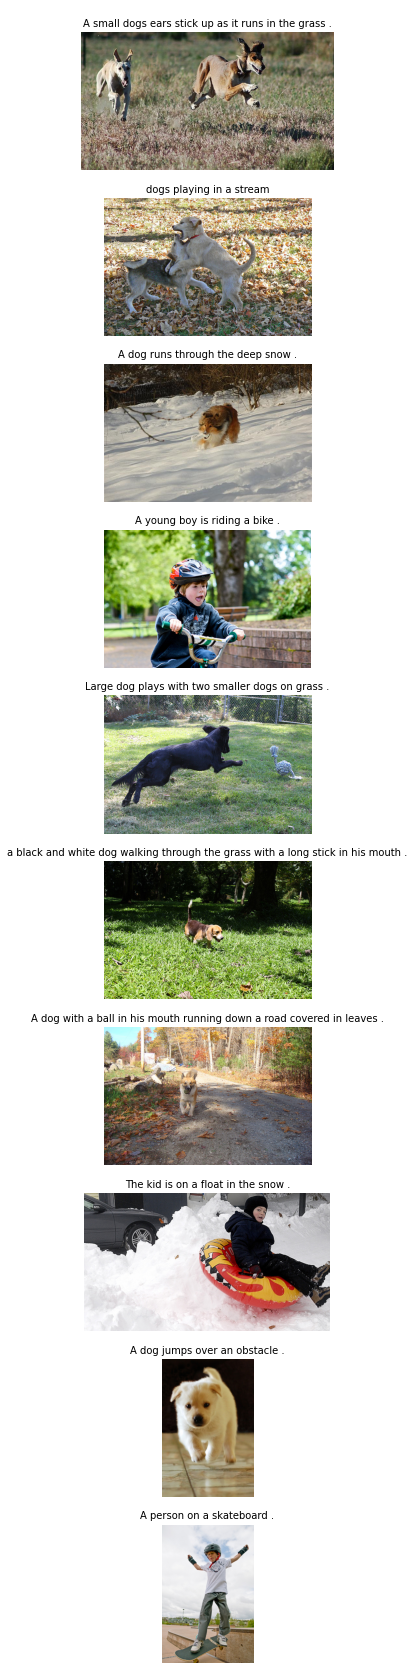

In [83]:
visual_dataset = train_dataset[train_dataset['positive'] > 0.5].sample(MAX_SAMPLE).copy()
visual_dataset.reset_index(inplace=True)

images = []
labels = []

for i in range(visual_dataset.shape[0]):
    images.append(f'{TRAIN_IMAGE_FOLDER}/{visual_dataset.iloc[i]["image"]}')
    labels.append(visual_dataset.iloc[i]['query_text'])

image_show(images, labels)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [84]:
# стоп-слова выбирались при помощи просмотра изображений и нахождения из описаний
stop_words = [
    'baby',
    'child',
    'little boy',
    'little girl',
    'kid',
    'young girl',
    'young boy',
    'boy',
    'girl'
]

In [85]:
def ban(txt):
    """
    Определение наличие стоп-слов

    Параметры:
    ----------
    txt: string - текст для анализа

    Результат:
    ----------
    boolean - результат обработки
    """
    txt = txt.lower()
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(txt)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

    for word in stop_words:
        word_len = len(word.split())

        if word_len > 1:
            if word in txt:
                return True
        elif word_len == 1:
            if word in txt.split():
                return True

    return False

In [86]:
train_dataset['ban'] = train_dataset['query_text'].apply(ban)

train_dataset[train_dataset['ban'] == True].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1200 entries, ('1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2') to ('757046028_ff5999f91b.jpg', '2061144717_5b3a1864f0.jpg#2')
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   query_text       1200 non-null   object 
 1   positive_crowd   410 non-null    float64
 2   positive_expert  1172 non-null   float64
 3   positive         1185 non-null   float64
 4   ban              1200 non-null   bool   
dtypes: bool(1), float64(3), object(1)
memory usage: 123.5+ KB


In [87]:
print(f'Будет удалено {len(train_dataset[train_dataset.ban == True])} записей')
train_dataset.drop(train_dataset[train_dataset.ban == True].index, inplace=True)
train_dataset.drop(columns=['ban'], inplace=True)

Будет удалено 1200 записей


# 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
# Step 1: Initialize the model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.to(device)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms(antialias=True)

# Step 3: Create the feature extractor with the required nodes
return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.3MB/s]


In [90]:
def get_image_vector(image_path):
    """
    Получение вектора изображения

    Параметры:
    ----------
    image_path: string - путь к изображению

    Результат:
    ----------
    torch.Tensor
    """

    # Step 4: Load the image(s) and apply inference preprocessing transforms
    image = read_image(image_path).unsqueeze(0)
    model_input = preprocess(image).to(device)

    with torch.no_grad():
        # Step 5: Extract the features
        features = feature_extractor(model_input)
        flatten_fts = features["flatten"].squeeze()

        # тут специально переводим на CPU
        return flatten_fts.to('cpu').detach().numpy()

In [91]:
# выберим одно изображение для проверки
get_image_vector(TRAIN_IMAGE_FOLDER + '/53043785_c468d6f931.jpg').shape

(512,)

In [92]:
# словарь для хранения результата обработки
image_vectors = {}

In [93]:
def images2vector(folder):
    count = 0

    for p in Path(folder).glob('*.jpg'):
        count+=1

    with tqdm(total=count) as pbar:
        for p in Path(folder).glob('*.jpg'):
            image_vectors[p.name] = get_image_vector(folder + f'/{p.name}')

            pbar.update(1)

In [94]:
# используем кэш
if os.path.exists(TMP + '/image_vectors.pickle'):
    image_vectors = pickle.load(open(TMP + '/image_vectors.pickle', 'rb'))
else:
    images2vector(TRAIN_IMAGE_FOLDER)
    pickle.dump(image_vectors, file = open(TMP + '/image_vectors.pickle', 'wb'))

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


In [95]:
# проверим сформированный объект
img1 = list(image_vectors.keys())[0]
image_vectors[img1].shape

(512,)

In [96]:
print(f'''Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной {image_vectors[img1].shape[0]}
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.''')

Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной 512
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [97]:
# обучать будем на специальной модели
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

model.to(device)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [98]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [99]:
def text2vector(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    pbar.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [100]:
# используем кэш
if os.path.exists(TMP + '/train_dataset.pickle'):
    train_dataset = pickle.load(open(TMP + '/train_dataset.pickle', 'rb'))
else:
    with tqdm(total=train_dataset.shape[0]) as pbar:
        train_dataset['text2vec'] = train_dataset['query_text'].apply(lambda x: text2vector(x))

    pickle.dump(train_dataset, file = open(TMP + '/train_dataset.pickle', 'wb'))

100%|██████████| 4622/4622 [12:21<00:00,  6.24it/s]


In [102]:
train_dataset.head()

,,query_text,positive_crowd,positive_expert,positive,text2vec
image,query_id,,,,,
1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024..."
3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024..."
463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024..."
488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024..."
534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024..."


In [103]:
print(f'После векторизации текста был создан Tensor размером {train_dataset.iloc[0]["text2vec"].shape}')

После векторизации текста был создан Tensor размером (768,)


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [104]:
train_dataset.reset_index(inplace=True)

In [105]:
def image2vector(row):
    """
    По имени изображения достаём его вектор, который был создан выше

    Параметры:
    ----------
    row: Serias

    Результат:
    ----------
    numpy.ndarray
    """
    img = row['image']
    return image_vectors[img]

In [106]:
train_dataset['image2vec'] = train_dataset.apply(image2vector, axis=1)

In [107]:
def join_vectors(row):
    """
    Объединяем два вектора, текст и изображение

    Параметры:
    ----------
    row: Serias

    Результаты:
    numpy.ndarray - объдинённый вектор
    """
    return np.concatenate((row['text2vec'], row['image2vec']))

In [108]:
train_dataset['vec'] = train_dataset.apply(join_vectors, axis=1)

In [109]:
df = train_dataset.copy()

In [110]:
df.head()

,image,query_id,query_text,positive_crowd,positive_expert,positive,text2vec,image2vec,vec
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024...","[0.66454345, 3.0099633, 2.8945675, 0.9445692, ...","[0.15153737, -0.09737329, -0.015055846, -0.024..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024...","[0.2731972, 2.4646437, 1.6143687, 1.2424315, 1...","[0.15153737, -0.09737329, -0.015055846, -0.024..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024...","[0.9738353, 3.8057532, 1.2916151, 0.800693, 0....","[0.15153737, -0.09737329, -0.015055846, -0.024..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024...","[1.5542969, 1.0708437, 0.17263255, 0.28900686,...","[0.15153737, -0.09737329, -0.015055846, -0.024..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,0.0,0.0,"[0.15153737, -0.09737329, -0.015055846, -0.024...","[0.33821726, 3.8320787, 1.1654177, 0.5147761, ...","[0.15153737, -0.09737329, -0.015055846, -0.024..."


In [111]:
print(f'Длина итогового вектора равна {df.iloc[0]["text2vec"].shape[0]} + {df.iloc[0]["image2vec"].shape[0]} = {len(df.iloc[0]["vec"])}')

Длина итогового вектора равна 768 + 512 = 1280


In [112]:
# удаляем те записи, у которых нет оценки (это раннее удалённые записи у экспертов, которые разошлись в оценке)
df.drop(df[df['positive'].isna()].index, inplace=True)
df = df.reset_index(drop=True)

In [113]:
print(f'Вывод: после объединения двух векторов мы получаем третьи вектор длиной {len(df.iloc[0]["vec"])}, который содержит конкатинированные признаки для дальнейшего обучения.')

Вывод: после объединения двух векторов мы получаем третьи вектор длиной 1280, который содержит конкатинированные признаки для дальнейшего обучения.


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [114]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['positive']), y=df['positive'], groups=df['image']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [115]:
features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))
features_test = torch.FloatTensor(list(test_df.loc[:, 'vec'].values))

/tmp/ipykernel_31/3748162826.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))


In [116]:
target_train = torch.FloatTensor(train_df['positive'].values).reshape(-1, 1)
target_test = torch.FloatTensor(test_df['positive'].values).reshape(-1, 1)

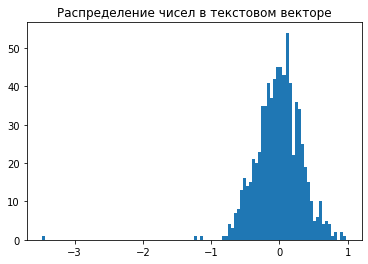

In [117]:
plt.hist(df.iloc[0]['text2vec'], bins=100)

plt.title('Распределение чисел в текстовом векторе')
plt.show()

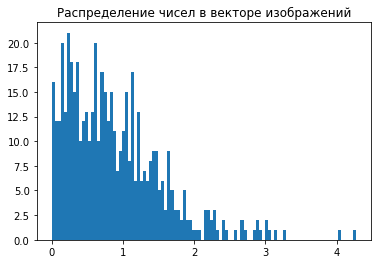

In [118]:
plt.hist(df.iloc[0]['image2vec'], bins=100)

plt.title('Распределение чисел в векторе изображений')
plt.show()

Вывод: так как, текст и изображения распределены по разному, сделаем ниже преобразование - масштабирование

In [119]:
class TorchStandardScaler:
    """
    Специальный класс для масштабирования Tensor
    """
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

In [121]:
# процесс масштабирования
scaler = TorchStandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### LinearRegression

Обучим модель LinearRegression на созданных данных. Для проверки качества модели, здесь и ниже, буду использовать метрику RMSE.

In [122]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [123]:
pred = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred) ** 0.5

print(f'RMSE для LinearRegression равно', round(rmse_lr, 3))

RMSE для LinearRegression равно 12.103


### Полносвязанная нейронная сеть

Далее проверим метрику качества на следуюшей модели

In [124]:
# создание датасета
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [125]:
# создадим DataLoader
train_dataset = CustomDataset(features_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(features_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [126]:
# проверим работу
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1280])
Labels batch shape: torch.Size([32, 1])


In [127]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1280, 10240)
        self.fc2 = nn.Linear(10240, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 64)
        self.fc6 = nn.Linear(64, 1)

        self.dp = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.dp(x)

        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc3(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc4(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc5(x)
        x = self.relu(x)
        #x = self.dp(x)

        x = self.fc6(x)

        return x

In [128]:
models = Net()
models.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 10
min_valid_loss = np.inf

Запустим обучение. Промежуточный результат будем сохранять есть метрика качества на последней эпохе лучше предыдущей.

In [129]:
for e in range(epochs):
    train_loss = 0.0
    models.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        target = models(data)
        loss = torch.sqrt(criterion(target,labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    valid_loss = 0.0
    models.eval()     # Optional when not using Model Specific layer

    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)

        target = models(data)
        loss = torch.sqrt(criterion(target, labels))
        valid_loss += loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(test_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(models.state_dict(), TMP + '/saved_model.pth')

Epoch 1 		 Training Loss: 9.833205511369327 		 Validation Loss: 9.269021713456443
Validation Loss Decreased(inf--->398.567934) 	 Saving The Model
Epoch 2 		 Training Loss: 8.956501212450537 		 Validation Loss: 8.957969981570576
Validation Loss Decreased(398.567934--->385.192709) 	 Saving The Model
Epoch 3 		 Training Loss: 8.296891762773589 		 Validation Loss: 8.789896399475808
Validation Loss Decreased(385.192709--->377.965545) 	 Saving The Model
Epoch 4 		 Training Loss: 7.5489901038679745 		 Validation Loss: 8.672761797904968
Validation Loss Decreased(377.965545--->372.928757) 	 Saving The Model
Epoch 5 		 Training Loss: 6.885210752782255 		 Validation Loss: 8.691725489705108
Epoch 6 		 Training Loss: 6.036536370173539 		 Validation Loss: 8.694713451141535
Epoch 7 		 Training Loss: 5.319548880699838 		 Validation Loss: 8.601527823958286
Validation Loss Decreased(372.928757--->369.865696) 	 Saving The Model
Epoch 8 		 Training Loss: 4.549953364352189 		 Validation Loss: 8.78203101490

По итогу, наилучшее качество показала модель на основе полносвязанной нейросети.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [131]:
# загрузим модель
models = Net()
models.to(device)

models.load_state_dict(torch.load(TMP + '/saved_model.pth'))
models.eval()

Net(
  (fc1): Linear(in_features=1280, out_features=10240, bias=True)
  (fc2): Linear(in_features=10240, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [130]:
test_images_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/test_images.csv')
test_images_csv.info()
test_images_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [132]:
test_queries_csv = pd.read_csv(ROOT_FOLDER + '/to_upload/test_queries.csv', sep='|', index_col=0)
test_queries_csv.info()
test_queries_csv.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
416,3722572342_6904d11d52.jpg#1,A red high speed racing boat skips across the ...,3722572342_6904d11d52.jpg
483,957682378_46c3b07bcd.jpg#3,Two dogs are wrestling in a field .,957682378_46c3b07bcd.jpg
49,191003283_992257f835.jpg#4,The baby is wearing a red shirt and walking in...,191003283_992257f835.jpg
429,381514859_b40418d9c3.jpg#4,Two white dogs chase after a red ball in a yar...,381514859_b40418d9c3.jpg
453,607339469_af851c4119.jpg#3,A little girl leans over the side of a wall to...,607339469_af851c4119.jpg


In [133]:
image_vectors = {}

# воспользуемся ранее созданным методом
images2vector(TEST_IMAGE_FOLDER)

100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


### Тестирование

Создадим специальную функцию для тестирования модели

In [134]:
# загружаю изображение, которое будет показываться при запрете
urllib.request.urlretrieve('https://upload.wikimedia.org/wikipedia/commons/f/f9/No-image-available.jpg', './cache/No-image-available.jpg')

('./cache/No-image-available.jpg', <http.client.HTTPMessage at 0x7f27496ecbb0>)

In [135]:
def search(txt):
    """
    Функция для поиска изображений по описанию

    Параметры:
    ----------
    txt: string - описание изображения

    Результат:
    ----------
    string - путь к изображению
    string - описание
    float - вероятность
    """
    if ban(txt):
        # Выводим сообщение связанное с юридическими ограничениями
        return './cache/No-image-available.jpg', f'{txt}\nThis image is unavailable in your country in compliance with local laws', None

    vec = text2vector(txt)

    # создадим данные для модели
    data = []
    images = []

    for key in image_vectors.keys():
        images.append(key)

        img = image_vectors[key]
        data.append(np.concatenate((vec, img)))

    with torch.no_grad():
        pred = models(scaler.transform(torch.FloatTensor(data)).to(device)).to('cpu')
        # получаем индекс записи, которая больше всего подходит под описание
        idx = pred.numpy().argmax(axis=0)[0]

    return f'{TEST_IMAGE_FOLDER}/{images[idx]}', txt, pred[idx].numpy()[0]

In [136]:
# получаем 10 случайных примеров из тестового dataset'а
queries = list(test_queries_csv.sample(MAX_SAMPLE)['query_text'])

In [137]:
images = []
labels = []
scores = []

for i in range(len(queries)):

    image_path, title, score = search(queries[i])

    images.append(image_path)
    if score == None:
        scores.append(None)
    else:
        scores.append(round(score, 3))
    labels.append(title)

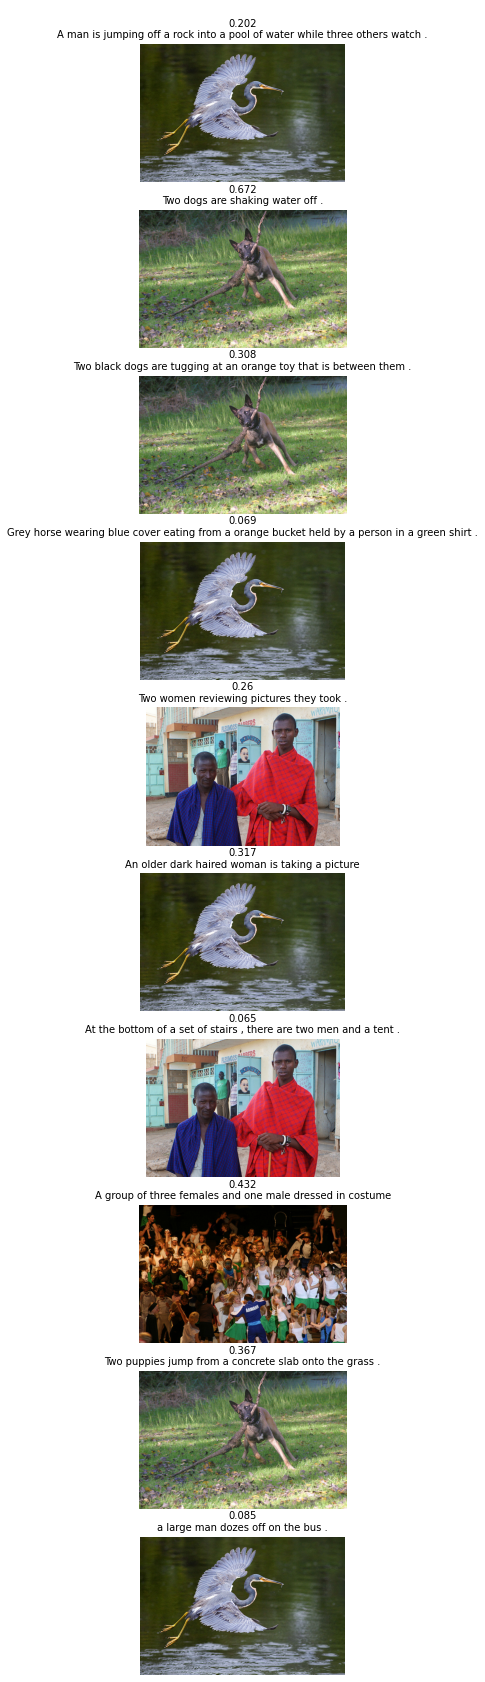

In [138]:
image_show(images, labels, scores)

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска

Наилучшее качество показывает модель на основе полносвзанной нейронной сети. Для улучшения качества модели возможно потребуется больше количество данных, а для определения "юридических ограниченний" одного вхождения стоп-слов недостаточно, наверно лучше сделать для этого отдельную модель.

Проект технически возможен, это доказывают поисковые системы. Дополнительно можно воспользоваться нейронными сетями основанными на CLIP от OpenAI, которая была обучена на большем количестве данных.